In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import Counter
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence

from pathlib import Path
import os

# custom modules
from models import Generator, Discriminator
from custom_dataset import CustomSequenceDataset
from preprocess_data import read_adfa_data, sequence_to_graph, fetch_graph_data
from utils import get_device, plot_loss_curve, evaluate_gcn_model
from classifiers import GCNModel
from train import train_gan_model
from train import train_gcn_model

# read, preprocess, and fetch the ADFA datasets


In [2]:
data_folder = "ADFA"  # make sure "ADFA" folder in the parent directory of this project's folder [ie., your codes]
current_directory = Path(os.getcwd())
parent_path = current_directory.parent.absolute()
# print(current_directory.parent.absolute())

full_data_folder_path = os.path.join(parent_path, data_folder)

In [3]:
from sklearn.model_selection import train_test_split


adfa_sub_folders = [
    "Training_Data_Master",
    "Validation_Data_Master",
    "Attack_Data_Master",
]

benign_training_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[0])
benign_validation_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[1])

attack_data_path = os.path.join(full_data_folder_path, adfa_sub_folders[2])


# read the sub folders
benign_train_sequences, benign_train_labels = read_adfa_data(benign_training_data_path)

benign_val_sequences, benign_val_labels = read_adfa_data(benign_validation_data_path)

attack_sequences, attack_labels = read_adfa_data(attack_data_path)

# the attack data are splitted into train and val data using 70% and 30% respectively.

# shuffle(
#     attack_sequences
# )  # shuffle the attack data so that the six attack categories are mixed up in the train and val data

# since, label is the 'same' = 1 for all the attack data, no need to shuffle it.
# split the attack_sequences
# n_samples = int(len(attack_sequences) * 0.7)
# train_attack_sequences = attack_sequences[:n_samples]
# train_attack_labels = attack_labels[:n_samples]

# val_attack_sequences = attack_sequences[n_samples:]
# val_attack_labels = attack_labels[n_samples:]


# Now, combine the both training data
# train_data = benign_train_sequences + train_attack_sequences
# train_labels = benign_train_labels + train_attack_labels

# combine all the data

# combine the validation data
# n_resample_benign  = int (1.2 * len(val_attack_sequences))
# n_resample_benign = int(len(val_attack_sequences))

# shuffle benign_val_sequences
# shuffle(benign_val_sequences)
# val_data = benign_val_sequences[:n_resample_benign] + val_attack_sequences
# val_labels = benign_val_labels[:n_resample_benign] + val_attack_labels

data = benign_train_sequences + benign_val_sequences + attack_sequences
labels = benign_train_labels + benign_val_labels + attack_labels

# perform  70 % training and 30% testing set split

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)

len(train_data), len(train_labels), len(test_data), len(test_labels)

Read 833 sequences from /Users/gere/Desktop/research projects/gan_models/ADFA/Training_Data_Master
Read 4372 sequences from /Users/gere/Desktop/research projects/gan_models/ADFA/Validation_Data_Master
Read 746 sequences from /Users/gere/Desktop/research projects/gan_models/ADFA/Attack_Data_Master


(4165, 4165, 1786, 1786)

In [4]:
len(attack_sequences)

746

In [5]:
# Data is imbalanced: 1666 samples of benign & 1051 samples of attack (malignant) will be used for training the GCN model
Counter(train_labels)

Counter({0: 3643, 1: 522})

In [6]:
Counter(test_labels)

Counter({0: 1562, 1: 224})

In [7]:
# Create a custom dataset
batch_size = 64
# convert train_data sequences and val_data sequences into graphs

train_graph_dataset = fetch_graph_data(train_data, train_labels)
val_graph_dataset = fetch_graph_data(test_data, test_labels)


# Create a data loader
graph_train_loader = DataLoader(
    train_graph_dataset, batch_size=batch_size, shuffle=True
)
graph_val_loader = DataLoader(val_graph_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# you can see the graph data: it has edge_index, weight, num_nodes, y (label of the graph, i.e., malign or benign), and x (node features). Here, x is a list of integers representing the node features. They need to be converted to a one-hot vector of size vocab_size or vector of embedded representation.
train_graph_dataset[0]

Data(edge_index=[2, 63], weight=[63], num_nodes=17, x=[1], y=0)

In [9]:
# device = get_device()
vocab_size = 342
hidden_dim = 128  # also the number of hidden nodes in the GCN. Can be set to 128, 256 or 512. If you have more GPU, you can increase it. However, you may face overfitting. Increase dropout if you face overfitting. Like dropout = 0.6, 0.7, 0.8
num_classes = 2
dropout = 0.4
output_dim = num_classes
# number of GCN layers, depending on your GPU, set it to any integer from 2 to 5.
num_layers = 3
EPOCHS_GCN = 35


device = torch.device("cpu")


gcn_model = GCNModel(
    in_channels=vocab_size,
    hidden_channels=hidden_dim,
    out_channels=num_classes,
    num_layers=num_layers,
    dropout=dropout,
).to(device)

train_losses, train_f1_scores = train_gcn_model(
    gcn_model,
    graph_train_loader,
    vocab_size=vocab_size,
    epochs=EPOCHS_GCN,
    device=device,
)

100%|██████████| 66/66 [00:01<00:00, 46.75it/s]


Epoch 1 / 35, Loss: 0.4657, F1 Score: 0.0000


100%|██████████| 66/66 [00:01<00:00, 43.78it/s]


Epoch 2 / 35, Loss: 0.4102, F1 Score: 0.3871


100%|██████████| 66/66 [00:01<00:00, 45.35it/s]


Epoch 3 / 35, Loss: 0.3989, F1 Score: 0.5086


100%|██████████| 66/66 [00:01<00:00, 45.85it/s]


Epoch 4 / 35, Loss: 0.3974, F1 Score: 0.5705


100%|██████████| 66/66 [00:01<00:00, 44.52it/s]


Epoch 5 / 35, Loss: 0.3919, F1 Score: 0.5676


100%|██████████| 66/66 [00:01<00:00, 45.23it/s]


Epoch 6 / 35, Loss: 0.3916, F1 Score: 0.6134


100%|██████████| 66/66 [00:01<00:00, 44.91it/s]


Epoch 7 / 35, Loss: 0.3911, F1 Score: 0.5992


100%|██████████| 66/66 [00:01<00:00, 40.72it/s]


Epoch 8 / 35, Loss: 0.3904, F1 Score: 0.5965


100%|██████████| 66/66 [00:01<00:00, 42.37it/s]


Epoch 9 / 35, Loss: 0.3934, F1 Score: 0.5763


100%|██████████| 66/66 [00:01<00:00, 45.42it/s]


Epoch 10 / 35, Loss: 0.3901, F1 Score: 0.6059


100%|██████████| 66/66 [00:01<00:00, 46.21it/s]


Epoch 11 / 35, Loss: 0.3874, F1 Score: 0.6146


100%|██████████| 66/66 [00:01<00:00, 44.27it/s]


Epoch 12 / 35, Loss: 0.3875, F1 Score: 0.6080


100%|██████████| 66/66 [00:01<00:00, 45.44it/s]


Epoch 13 / 35, Loss: 0.3916, F1 Score: 0.5964


100%|██████████| 66/66 [00:01<00:00, 43.07it/s]


Epoch 14 / 35, Loss: 0.3880, F1 Score: 0.6127


100%|██████████| 66/66 [00:01<00:00, 38.55it/s]


Epoch 15 / 35, Loss: 0.3863, F1 Score: 0.6097


100%|██████████| 66/66 [00:01<00:00, 41.09it/s]


Epoch 16 / 35, Loss: 0.3893, F1 Score: 0.6191


100%|██████████| 66/66 [00:01<00:00, 40.97it/s]


Epoch 17 / 35, Loss: 0.3859, F1 Score: 0.6115


100%|██████████| 66/66 [00:01<00:00, 43.55it/s]


Epoch 18 / 35, Loss: 0.3865, F1 Score: 0.6194


100%|██████████| 66/66 [00:01<00:00, 43.52it/s]


Epoch 19 / 35, Loss: 0.3858, F1 Score: 0.6320


100%|██████████| 66/66 [00:01<00:00, 44.71it/s]


Epoch 20 / 35, Loss: 0.3852, F1 Score: 0.6320


100%|██████████| 66/66 [00:01<00:00, 45.22it/s]


Epoch 21 / 35, Loss: 0.3870, F1 Score: 0.6241


100%|██████████| 66/66 [00:01<00:00, 41.82it/s]


Epoch 22 / 35, Loss: 0.3842, F1 Score: 0.6448


100%|██████████| 66/66 [00:01<00:00, 44.93it/s]


Epoch 23 / 35, Loss: 0.3931, F1 Score: 0.5899


100%|██████████| 66/66 [00:01<00:00, 42.99it/s]


Epoch 24 / 35, Loss: 0.3855, F1 Score: 0.6493


100%|██████████| 66/66 [00:01<00:00, 44.56it/s]


Epoch 25 / 35, Loss: 0.3838, F1 Score: 0.6531


100%|██████████| 66/66 [00:01<00:00, 45.26it/s]


Epoch 26 / 35, Loss: 0.3829, F1 Score: 0.6329


100%|██████████| 66/66 [00:01<00:00, 45.58it/s]


Epoch 27 / 35, Loss: 0.3824, F1 Score: 0.6336


100%|██████████| 66/66 [00:01<00:00, 43.48it/s]


Epoch 28 / 35, Loss: 0.3793, F1 Score: 0.6812


100%|██████████| 66/66 [00:01<00:00, 44.68it/s]


Epoch 29 / 35, Loss: 0.3709, F1 Score: 0.7189


100%|██████████| 66/66 [00:01<00:00, 44.82it/s]


Epoch 30 / 35, Loss: 0.3691, F1 Score: 0.7300


100%|██████████| 66/66 [00:01<00:00, 43.98it/s]


Epoch 31 / 35, Loss: 0.3692, F1 Score: 0.7459


100%|██████████| 66/66 [00:01<00:00, 45.19it/s]


Epoch 32 / 35, Loss: 0.3677, F1 Score: 0.7357


100%|██████████| 66/66 [00:01<00:00, 44.72it/s]


Epoch 33 / 35, Loss: 0.3650, F1 Score: 0.7527


100%|██████████| 66/66 [00:01<00:00, 42.50it/s]


Epoch 34 / 35, Loss: 0.3670, F1 Score: 0.7546


100%|██████████| 66/66 [00:01<00:00, 44.28it/s]

Epoch 35 / 35, Loss: 0.3646, F1 Score: 0.7568


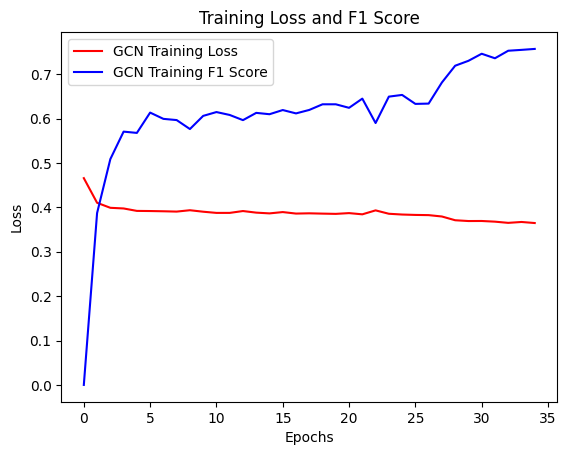

In [10]:
x = np.arange(EPOCHS_GCN, dtype=int)
plt.plot(x, train_losses, color="red", label="GCN Training Loss")
plt.plot(x, train_f1_scores, color="blue", label="GCN Training F1 Score")
plt.title("Training Loss and F1 Score")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
evaluate_gcn_model(gcn_model, graph_val_loader, vocab_size=vocab_size, device=device)

GCN performance:
Accuracy: 0.9569
Precision: 0.9252
Recall: 0.8702
F1 score: 0.8950
MCC: 0.7935


In [12]:
# PREPARE DATASET FOR GAN MODEL: pad the sequences to make them of same length, then trim them to a fixed sequence length to avoid too much padding.
# convert train_data sequences and val_data sequences into graphs
SEQUENCE_LENGTH = 100
train_data_padded = pad_sequence(
    [torch.tensor(sequence, dtype=torch.long) for sequence in train_data],
    batch_first=True,
)
val_data_padded = pad_sequence(
    [torch.tensor(sequence, dtype=torch.long) for sequence in test_data],
    batch_first=True,
)

train_data_padded.shape, val_data_padded.shape

(torch.Size([4165, 4094]), torch.Size([1786, 4494]))

In [13]:
train_data_padded[:, SEQUENCE_LENGTH].shape, val_data_padded[:SEQUENCE_LENGTH].shape

# our dataset will be of shape (n_samples, SEQUENCE_LENGTH).
train_dataset = CustomSequenceDataset(
    train_data_padded[:, :SEQUENCE_LENGTH], train_labels
)
val_dataset = CustomSequenceDataset(val_data_padded[:, :SEQUENCE_LENGTH], test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# hyperparameters of the generator and discriminator of the GAN model
latent_dim = 100
hidden_dim = 128
vocab_size = 342  # we have 342 unique system calls in the ADFA dataset
seq_len = SEQUENCE_LENGTH  # sequence length of the ADFA dataset with less than 120, will be padded. If sequence is longer than 120, it will be truncated.
output_dim = vocab_size
embed_dim = 10
dropout = 0.5
batch_size = 32
n_samples = 1000
num_classes = 2
lr = 1e-4  # 2e-6
epochs = 50
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
device = get_device()
temperature = 0.2  # 0.1

gen = Generator(
    latent_dim,
    seq_len,
    hidden_dim,
    output_dim,
    embed_dim,
    dropout,
    conditional_info=True,
    num_classes=num_classes,
).to(device)
# gen = Gen(latent_dim, hidden_dim, seq_len, output_dim, embed_dim, dropout).to(device)

disc = Discriminator(
    vocab_size,
    seq_len,
    hidden_dim,
    embed_dim,
    dropout,
    conditional_info=True,
    num_classes=num_classes,
).to(device)

gen_optimizer = Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

disc_optimizer = Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

In [15]:
device = get_device()

In [16]:
# input_data = torch.randint(0, vocab_size, (n_samples, seq_len))
# input_labels = torch.randint(0, num_classes, (n_samples,))
# train_dataset = CustomSequenceDataset(input_data, input_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
# note that the temperature is set to any value between 0 and 1.
g_losses, d_losses = train_gan_model(
    gen,
    disc,
    gen_optimizer,
    disc_optimizer,
    train_loader,
    epochs,
    vocab_size,
    device=device,
    tau=temperature,
)

Epoch 1 / 50


100%|██████████| 66/66 [00:04<00:00, 14.27it/s]


D Loss: 1.4050, G Loss: -0.6717
Epoch 2 / 50


100%|██████████| 66/66 [00:04<00:00, 16.17it/s]


D Loss: 1.3745, G Loss: -0.6830
Epoch 3 / 50


100%|██████████| 66/66 [00:04<00:00, 15.64it/s]


D Loss: 1.3851, G Loss: -0.6930
Epoch 4 / 50


100%|██████████| 66/66 [00:04<00:00, 15.55it/s]


D Loss: 1.3788, G Loss: -0.6916
Epoch 5 / 50


100%|██████████| 66/66 [00:04<00:00, 15.15it/s]


D Loss: 1.3864, G Loss: -0.6946
Epoch 6 / 50


100%|██████████| 66/66 [00:04<00:00, 14.91it/s]


D Loss: 1.3968, G Loss: -0.6848
Epoch 7 / 50


100%|██████████| 66/66 [00:04<00:00, 15.06it/s]


D Loss: 1.3853, G Loss: -0.6909
Epoch 8 / 50


100%|██████████| 66/66 [00:04<00:00, 14.68it/s]


D Loss: 1.3904, G Loss: -0.6874
Epoch 9 / 50


100%|██████████| 66/66 [00:04<00:00, 14.73it/s]


D Loss: 1.3913, G Loss: -0.7002
Epoch 10 / 50


100%|██████████| 66/66 [00:04<00:00, 14.62it/s]


D Loss: 1.3797, G Loss: -0.6944
Epoch 11 / 50


100%|██████████| 66/66 [00:04<00:00, 14.22it/s]


D Loss: 1.3851, G Loss: -0.6934
Epoch 12 / 50


100%|██████████| 66/66 [00:04<00:00, 14.00it/s]


D Loss: 1.3831, G Loss: -0.6848
Epoch 13 / 50


100%|██████████| 66/66 [00:04<00:00, 13.83it/s]


D Loss: 1.3761, G Loss: -0.6990
Epoch 14 / 50


100%|██████████| 66/66 [00:04<00:00, 14.02it/s]


D Loss: 1.3888, G Loss: -0.6913
Epoch 15 / 50


100%|██████████| 66/66 [00:04<00:00, 13.93it/s]


D Loss: 1.3933, G Loss: -0.6942
Epoch 16 / 50


100%|██████████| 66/66 [00:04<00:00, 13.74it/s]


D Loss: 1.3907, G Loss: -0.6868
Epoch 17 / 50


100%|██████████| 66/66 [00:04<00:00, 13.71it/s]


D Loss: 1.3922, G Loss: -0.6994
Epoch 18 / 50


100%|██████████| 66/66 [00:04<00:00, 13.64it/s]


D Loss: 1.3766, G Loss: -0.6980
Epoch 19 / 50


100%|██████████| 66/66 [00:05<00:00, 11.75it/s]


D Loss: 1.3773, G Loss: -0.7009
Epoch 20 / 50


100%|██████████| 66/66 [00:05<00:00, 12.32it/s]


D Loss: 1.3862, G Loss: -0.6828
Epoch 21 / 50


100%|██████████| 66/66 [00:05<00:00, 11.82it/s]


D Loss: 1.3818, G Loss: -0.6874
Epoch 22 / 50


100%|██████████| 66/66 [00:05<00:00, 12.84it/s]


D Loss: 1.3944, G Loss: -0.6947
Epoch 23 / 50


100%|██████████| 66/66 [00:05<00:00, 12.57it/s]


D Loss: 1.3835, G Loss: -0.6886
Epoch 24 / 50


100%|██████████| 66/66 [00:05<00:00, 12.91it/s]


D Loss: 1.3958, G Loss: -0.6986
Epoch 25 / 50


100%|██████████| 66/66 [00:05<00:00, 11.54it/s]


D Loss: 1.3903, G Loss: -0.6884
Epoch 26 / 50


100%|██████████| 66/66 [00:05<00:00, 12.42it/s]


D Loss: 1.3885, G Loss: -0.6901
Epoch 27 / 50


100%|██████████| 66/66 [00:05<00:00, 12.53it/s]


D Loss: 1.3818, G Loss: -0.6826
Epoch 28 / 50


100%|██████████| 66/66 [00:05<00:00, 12.64it/s]


D Loss: 1.3928, G Loss: -0.6973
Epoch 29 / 50


100%|██████████| 66/66 [00:05<00:00, 11.62it/s]


D Loss: 1.3819, G Loss: -0.6927
Epoch 30 / 50


100%|██████████| 66/66 [00:05<00:00, 12.68it/s]


D Loss: 1.3831, G Loss: -0.6929
Epoch 31 / 50


100%|██████████| 66/66 [00:05<00:00, 12.93it/s]


D Loss: 1.3888, G Loss: -0.6994
Epoch 32 / 50


100%|██████████| 66/66 [00:05<00:00, 12.75it/s]


D Loss: 1.3928, G Loss: -0.6885
Epoch 33 / 50


100%|██████████| 66/66 [00:05<00:00, 12.71it/s]


D Loss: 1.3759, G Loss: -0.6953
Epoch 34 / 50


100%|██████████| 66/66 [00:05<00:00, 11.88it/s]


D Loss: 1.3850, G Loss: -0.6977
Epoch 35 / 50


100%|██████████| 66/66 [00:05<00:00, 12.06it/s]


D Loss: 1.3882, G Loss: -0.6959
Epoch 36 / 50


100%|██████████| 66/66 [00:05<00:00, 12.49it/s]


D Loss: 1.3771, G Loss: -0.6893
Epoch 37 / 50


100%|██████████| 66/66 [00:05<00:00, 13.03it/s]


D Loss: 1.3822, G Loss: -0.6968
Epoch 38 / 50


100%|██████████| 66/66 [00:04<00:00, 13.32it/s]


D Loss: 1.3957, G Loss: -0.6957
Epoch 39 / 50


100%|██████████| 66/66 [00:05<00:00, 13.00it/s]


D Loss: 1.3912, G Loss: -0.6934
Epoch 40 / 50


100%|██████████| 66/66 [00:04<00:00, 13.54it/s]


D Loss: 1.3866, G Loss: -0.6849
Epoch 41 / 50


100%|██████████| 66/66 [00:04<00:00, 13.45it/s]


D Loss: 1.3844, G Loss: -0.6976
Epoch 42 / 50


100%|██████████| 66/66 [00:05<00:00, 12.12it/s]


D Loss: 1.3881, G Loss: -0.6948
Epoch 43 / 50


100%|██████████| 66/66 [00:04<00:00, 13.98it/s]


D Loss: 1.3805, G Loss: -0.6944
Epoch 44 / 50


100%|██████████| 66/66 [00:04<00:00, 13.88it/s]


D Loss: 1.3845, G Loss: -0.6885
Epoch 45 / 50


100%|██████████| 66/66 [00:04<00:00, 13.64it/s]


D Loss: 1.3790, G Loss: -0.6967
Epoch 46 / 50


100%|██████████| 66/66 [00:04<00:00, 13.71it/s]


D Loss: 1.3780, G Loss: -0.6866
Epoch 47 / 50


100%|██████████| 66/66 [00:04<00:00, 13.76it/s]


D Loss: 1.3803, G Loss: -0.6896
Epoch 48 / 50


100%|██████████| 66/66 [00:04<00:00, 13.57it/s]


D Loss: 1.3945, G Loss: -0.7043
Epoch 49 / 50


100%|██████████| 66/66 [00:04<00:00, 14.16it/s]


D Loss: 1.3863, G Loss: -0.6950
Epoch 50 / 50


100%|██████████| 66/66 [00:04<00:00, 14.11it/s]

D Loss: 1.3864, G Loss: -0.6895


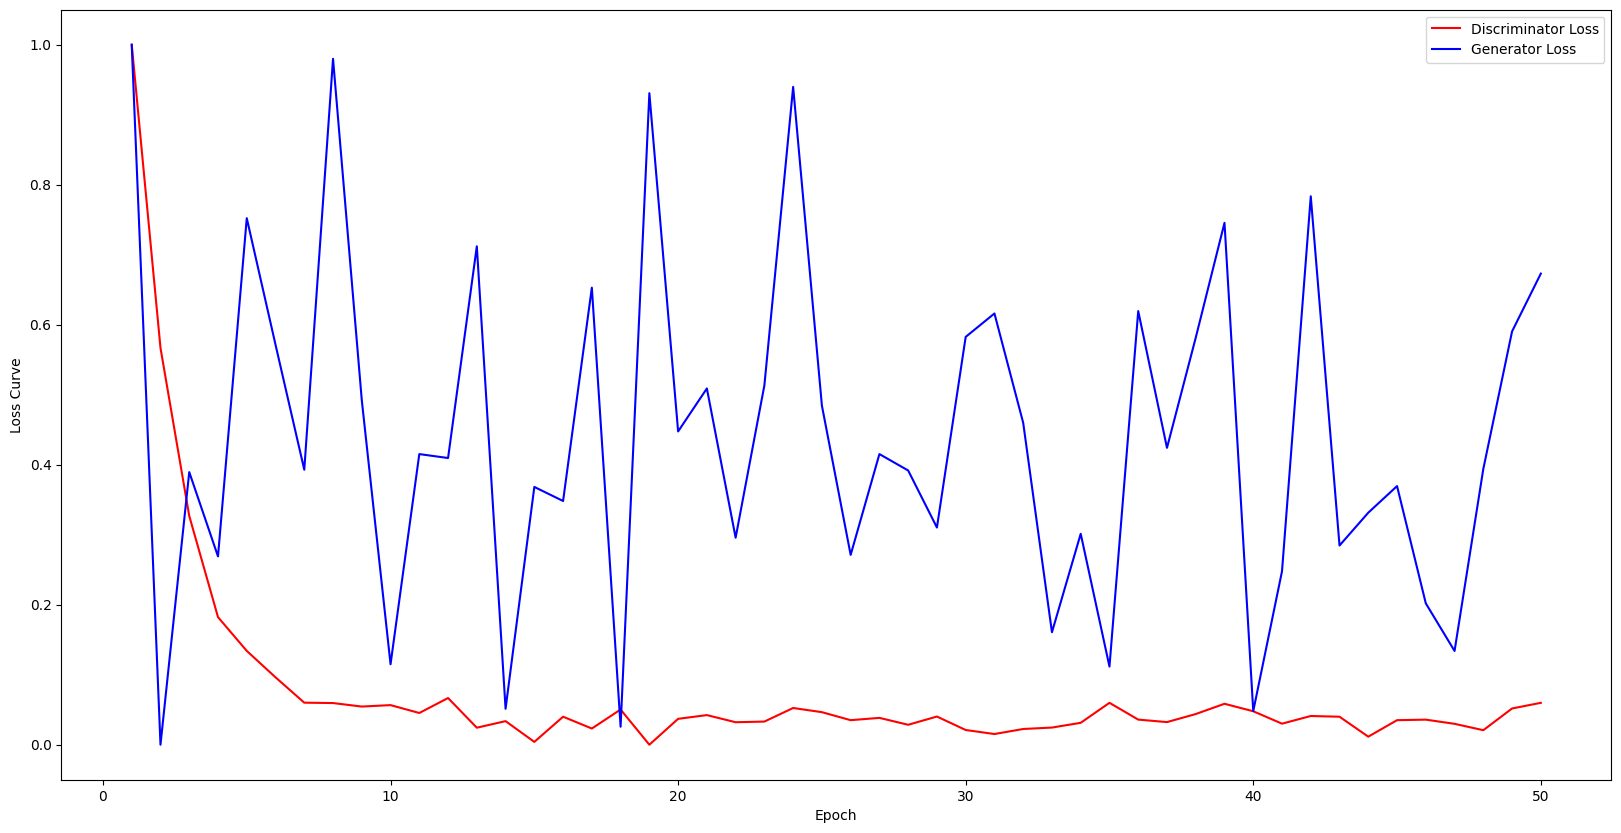

In [18]:
plot_loss_curve(g_losses, d_losses, epochs)

## generate fake samples


In [19]:
fake_labels = torch.randint(0, num_classes, (n_samples,), dtype=torch.long)
z = torch.randn((n_samples, latent_dim))

# print("random noise shape", z.shape)
# set generator to eval mode
gen.eval()

fake_data = gen(z.to(device), fake_labels.to(device)).detach().cpu()

# print the generated data: if the data contains nan values, it means that there is gradient explosion, or other issues. To avoid such problems, change the termperature value to be between 0.1 and 0.5. Also, trying changing the learning rate to be between 5e-6 and 1e-4. Of course, this is just a suggestion. You might experiment with other values if you want, and report your findings.
# print(fake_data[0])

In [20]:
# get the generated samples as tokens (this are a sequence tokens or words / characters, represented by integers .)
from pprint import pprint

fake_samples = torch.argmax(fake_data, dim=-1).cpu().numpy()

# now, let's see two generated sequences
pprint(fake_samples[:2])

array([[ 67, 286, 206,  47, 156, 247,  71,  45, 241,   7, 234, 205,  68,
        243,  12, 333, 291,  84, 131,  66, 282, 338,  55, 339, 108, 162,
        269, 301, 195, 238, 180, 272,   0, 184, 130, 185, 169, 306, 279,
        236, 216,  25, 245, 209,  52,   4,  82,  34,  90, 161, 305, 180,
         22, 318,  84, 189, 197, 325,  89,  27, 276,  80,  10, 210, 155,
        153, 245, 202,  35,   7,  66,  58, 153,  17, 118,  50, 339, 238,
        311,  36, 222, 229,  71,  23, 208,  43, 167, 152, 223,  57, 128,
        165, 191, 114, 208, 123,  98, 257,  67, 172],
       [173, 178,  79,  74,  20, 219, 113, 155, 291, 277, 215, 100,   3,
        224,  79,  46,  63,  35, 196, 121, 252, 209, 138, 310, 207,  45,
         11, 115, 239, 211,  36, 144,  61, 296, 333, 255, 302, 313, 148,
        170,  25, 323,  42, 135, 108, 149,  84, 276,  70, 304,   6, 196,
        208, 255, 175, 337,  23,  34, 149, 287,  52,  31, 126,  49, 109,
        239, 339, 283,  27, 101, 133,  29, 268,  96, 330, 293, 104, 28

# Now, we can generate from generated tokens (i.e., sequence)

` To do so, we can use the sequence_to_graph() function given in the preprocess_data.py`


In [21]:
# convert the generated samples into a networkx graph and also pytorch_geometric graph data object
networkx_graph, pytorch_geometric_data = sequence_to_graph(fake_samples[0])

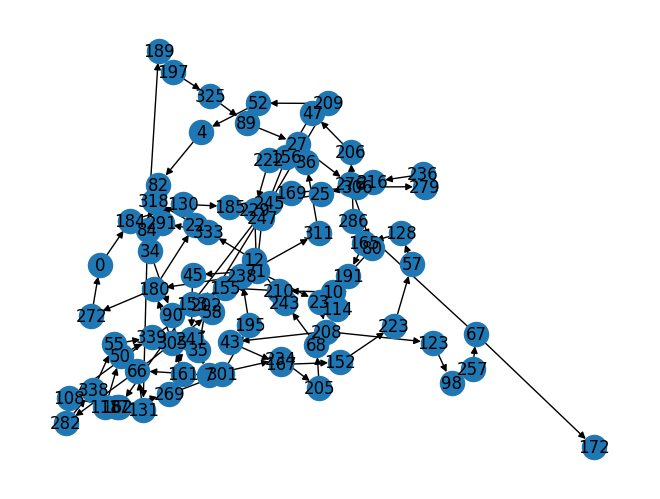

In [22]:
# you can see the networkx graph we generated
nx.draw(networkx_graph, with_labels=True)
plt.show()

# The Remaining Steps:

```
1 - generate many fake samples (sequences and their corresponding labels),

2 - add these fake sequences to train_data sequences, and add their fake_labels (benign or malign) to the trian_labels

3 - train a new GCNModel and compare performance before and after adding fake samples.


```
